In [104]:
# %cd ../..
# %run cryptolytic/notebooks/init.ipynb
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
import tensorflow as tf
import cryptolytic.util as util
import cryptolytic.start as start
import cryptolytic.viz.plot as plot
import cryptolytic.data.sql as sql
import cryptolytic.data as d
from cryptolytic.util import *
import cryptolytic.data.historical as h
import cryptolytic.model as m
import cryptolytic.model.lstm_framework as lstm
import cryptolytic.model.model_framework as mfw
import cryptolytic.model.data_work as dw
import cryptolytic.model.hyperparameter as hyper
import cryptolytic.model.cron_model as cron_model


from matplotlib.pylab import rcParams
from IPython.core.display import HTML
from pandas.plotting import register_matplotlib_converters # to stop a warning message
import cryptolytic.model.model_framework as mf

ohclv = ['open', 'high', 'close', 'low', 'volume']
plt.style.use('ggplot')
rcParams['figure.figsize'] = 20,7
start.init()
register_matplotlib_converters()


# Make math readable
HTML("""
<style>
.MathJax {
    font-size: 2rem;
}
</style>""")

In [2]:
import os
history_size = 400
input_len = 16000
lahead = 12*3
step = 2
period = 300
to_drop = lahead - 1
input_len = input_len + to_drop
batch_size = 200

df_orig = None
df_orig = d.get_df({'start':'06-01-2019', 'period':period, 'trading_pair':'btc_usd', 'exchange_id':'bitfinex'},
               n=input_len)

c:\Users\kyleh\Desktop\Repos\cryptolytic-ds\cryptolytic\data\__init__.py:54: FutureWarning:

how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)



In [3]:
import ta
df = df_orig
df = df.sort_index()
df = df._get_numeric_data().drop(["period"], axis=1, errors='ignore')
df = df.filter(regex="(?!timestamp_.*)", axis=1) # filter out timestapm_ metrics
df = ta.add_all_ta_features(df, open="open", high="high", low="low", close="close", volume="volume").dropna(axis=1)
df_diff = (df - df.shift(1, fill_value=0)).rename(lambda x: x+'_diff', axis=1)
df = pd.concat([df, df_diff], axis=1)
dataset = dw.normalize(df.values)
target = df.columns.get_loc('close') 
y = dataset[:, target]
history = {'loss' : [], 'val_loss' : []}

C:\Users\kyleh\Anaconda3\lib\site-packages\ta\trend.py:543: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\kyleh\Anaconda3\lib\site-packages\ta\trend.py:547: RuntimeWarning:

invalid value encountered in double_scalars



In [4]:
x_train, y_train, x_val, y_val = dw.windowed(dataset, target, batch_size, history_size, step, lahead)

In [5]:
print ('Single window of past history : {}'.format(x_train[0].shape))
print ('\n Number of candles to predict : {}'.format(y_train[0].shape))

Single window of past history : (200, 112)

 Number of candles to predict : (36,)


In [18]:
models = hyper.run_tuning(x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val)

- loss: 1.15 4400/12400 [=========>....................] - ETA: 11s - loss: 1.13 4600/12400 [==========>...................] - ETA: 11s - loss: 1.10 4800/12400 [==========>...................] - ETA: 11s - loss: 1.08 5000/12400 [===========>..................] - ETA: 10s - loss: 1.06 5200/12400 [===========>..................] - ETA: 10s - loss: 1.04 5400/12400 [============>.................] - ETA: 10s - loss: 1.02 5600/12400 [============>.................] - ETA: 9s - loss: 1.002 5800/12400 [=============>................] - ETA: 9s - loss: 0.984 6000/12400 [=============>................] - ETA: 9s - loss: 0.969 6200/12400 [==============>...............] - ETA: 8s - loss: 0.955 6400/12400 [==============>...............] - ETA: 8s - loss: 0.953 6600/12400 [==============>...............] - ETA: 8s - loss: 0.950 6800/12400 [===============>..............] - ETA: 7s - loss: 0.939 7000/12400 [===============>..............] - ETA: 7s - loss: 0.926 7200/12400 [================>......

NameError: name 'save_model' is not defined

In [20]:
params = {'filters1': 32, 'noise1': 0.007044669933974564, 'filtershape1': [48, 48, 96], 'filtershape2': [64, 64, 128]}
model = mfw.create_model(x_train, params)

(200, 100, 96)
(200, 200, 112)


In [102]:
model = mfw.fit_model(model, x_train, y_train, x_val, y_val)

ValueError: Input arrays should have the same number of samples as target arrays. Found 12400 input samples and 15600 target samples.

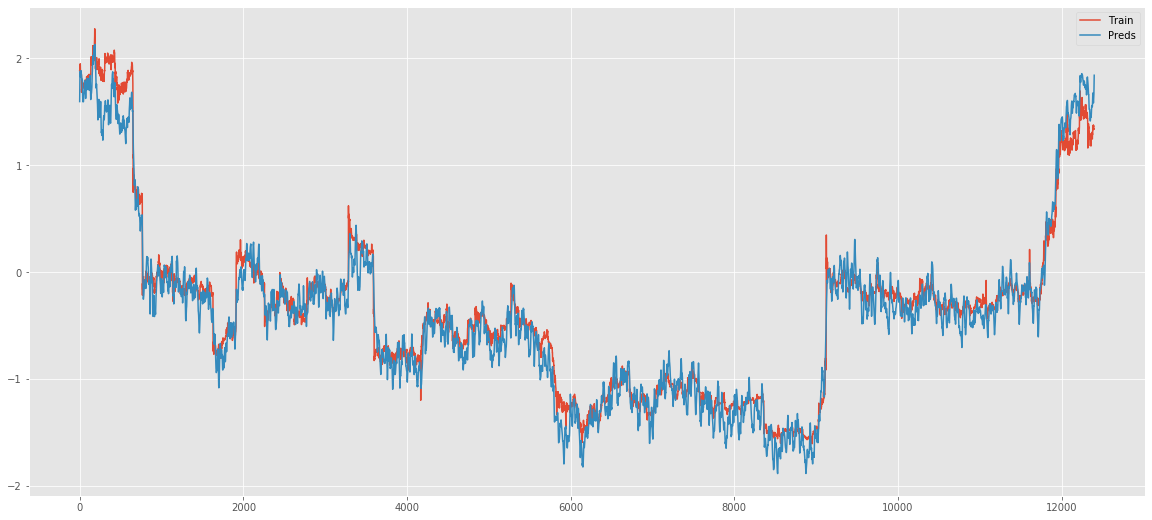

In [23]:
# Predictions on training set
rcParams['figure.figsize'] = 20,9
preds = model.predict(x_train)[:, 0]
n = len(preds)
h = history_size
hn = n+history_size
yo= len(x_val)+history_size
z = yo
modman = len(df)% batch_size
w = z + len(df)%modman

# plt.plot(range(n), d.denoise(df['close'][h:hn], 400), label='actual', color='green')
# plt.plot(range(n), d.denoise(preds[:n], 5), label='predicted');
# plt.plot(range(n), df.close_mean.values[h:hn], label='Mean')

plt.plot(y_train[:, 0], label='Train')
plt.plot(d.denoise(preds, 5), label='Preds')
plt.legend();

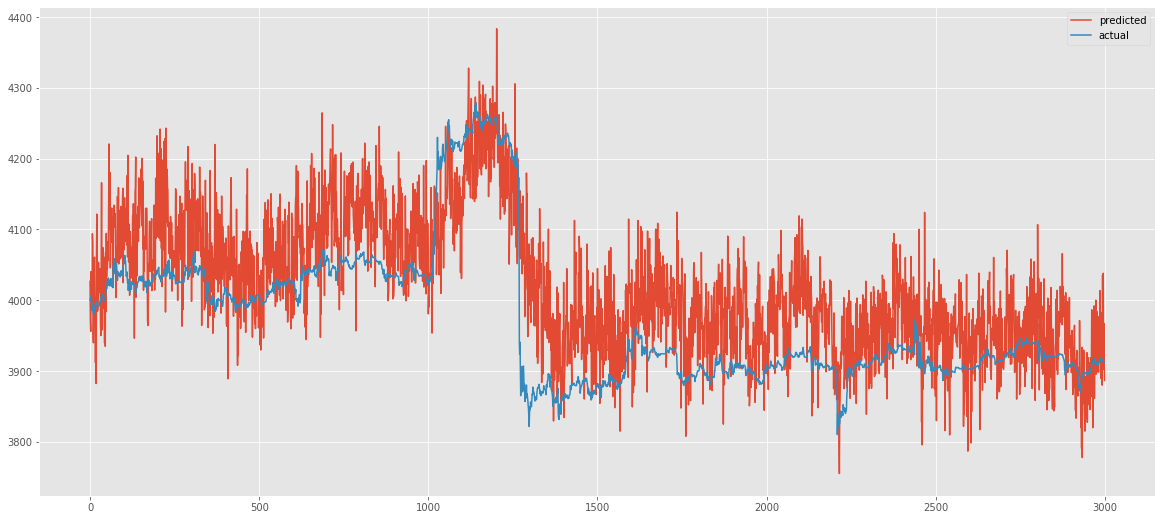

In [26]:
# Predictions on validation set
yo = dw.denormalize(model.predict(x_val)[:, 0], df, 'close')
y_actual = dw.denormalize(y_val[:, 0], df, 'close')
plt.plot(yo, label='predicted')
plt.plot(y_actual, label='actual')
plt.legend()

In [105]:
cron_model.run_model()

: 9s - loss: 0.04717600/25200 [===================>..........] - ETA: 9s - loss: 0.04717800/25200 [====================>.........] - ETA: 9s - loss: 0.04718000/25200 [====================>.........] - ETA: 9s - loss: 0.04618200/25200 [====================>.........] - ETA: 8s - loss: 0.04618400/25200 [====================>.........] - ETA: 8s - loss: 0.04618600/25200 [=====================>........] - ETA: 8s - loss: 0.04618800/25200 [=====================>........] - ETA: 8s - loss: 0.04619000/25200 [=====================>........] - ETA: 7s - loss: 0.04619200/25200 [=====================>........] - ETA: 7s - loss: 0.04619400/25200 [======================>.......] - ETA: 7s - loss: 0.04619600/25200 [======================>.......] - ETA: 7s - loss: 0.04619800/25200 [======================>.......] - ETA: 6s - loss: 0.04720000/25200 [======================>.......] - ETA: 6s - loss: 0.04820200/25200 [=======================>......] - ETA: 6s - loss: 0.04820400/25200 [=================

In [106]:
preds, y_train, df = cron_model.cron_pred()

df                          api  exchange trading_pair   timestamp  period  \
datetime                                                                   
2019-12-03 12:35:00  bitfinex  bitfinex      btc_usd  1575376500     300   
2019-12-03 12:40:00  bitfinex  bitfinex      btc_usd  1575376800     300   
2019-12-03 12:45:00  bitfinex  bitfinex      btc_usd  1575377100     300   
2019-12-03 12:50:00  bitfinex  bitfinex      btc_usd  1575377400     300   
2019-12-03 12:55:00  bitfinex  bitfinex      btc_usd  1575377700     300   
2019-12-03 13:00:00  bitfinex  bitfinex      btc_usd  1575378000     300   
2019-12-03 13:05:00  bitfinex  bitfinex      btc_usd  1575378300     300   
2019-12-03 13:10:00  bitfinex  bitfinex      btc_usd  1575378600     300   
2019-12-03 13:15:00  bitfinex  bitfinex      btc_usd  1575378900     300   
2019-12-03 13:20:00  bitfinex  bitfinex      btc_usd  1575379200     300   
2019-12-03 13:25:00  bitfinex  bitfinex      btc_usd  1575379500     300   
2019-12-03

In [107]:
preds.shape, y_train.shape, df.shape

((15600, 36), (15600, 0), (16010, 112))

In [74]:
df.head()

,timestamp,open,close,high,low,volume,high_m_low,close_m_open,arb_diff,arb_signal,...,trend_psar_diff,trend_psar_up_indicator_diff,trend_psar_down_indicator_diff,momentum_rsi_diff,momentum_stoch_diff,momentum_stoch_signal_diff,momentum_wr_diff,momentum_ao_diff,others_dr_diff,others_cr_diff
datetime,,,,,,,,,,,,,,,,,,,,,
2019-12-03 11:05:00,1575371100,7323.3,7335.100000,7340.000000,7323.3,25.579491,16.700000,11.800000,28.263333,0.386807,...,7335.100000,0.0,0.0,100.0,70.658683,70.658683,-29.341317,0.0,-4.981256,0.000000
2019-12-03 11:10:00,1575371400,7335.1,7335.072399,7335.100000,7335.0,0.531178,0.100000,-0.027601,31.778266,0.435122,...,-0.027601,0.0,0.0,-100.0,-0.165277,-0.082639,-0.165277,0.0,4.980879,-0.000376
2019-12-03 11:15:00,1575371700,7335.0,7323.900000,7335.018006,7323.9,5.329111,11.118006,-11.100000,31.143333,0.427045,...,4.927601,0.0,1.0,0.0,-66.900591,-22.327743,-66.900591,0.0,-0.151938,-0.152314
2019-12-03 11:20:00,1575372000,7323.9,7319.700000,7323.900000,7316.0,11.507762,7.900000,-4.200000,28.073333,0.385008,...,-0.322000,0.0,-1.0,0.0,11.823852,-18.414005,11.823852,0.0,0.094968,-0.057259
2019-12-03 11:25:00,1575372300,7319.7,7315.100000,7319.800000,7315.1,4.007049,4.700000,-4.600000,31.433333,0.431559,...,-0.947120,0.0,0.0,0.0,-15.416667,-23.497802,-15.416667,0.0,-0.005498,-0.062712


In [75]:
df.shape

(16028, 112)

In [108]:
rcParams['figure.figsize'] = 20,9
n = len(preds)
h = history_size
hn = n+history_size
yo= len(x_val)+history_size
z = yo
modman = len(df)% batch_size
w = z + len(df)%modman

# df = df.reset_index()

# plt.plot(range(n), d.denoise(df['close'][h:hn], 400), label='actual', color='green')
# plt.plot(range(n), d.denoise(preds[:n], 5), label='predicted');
# plt.plot(range(n), df.close_mean.values[h:hn], label='Mean')

de_preds = dw.denormalize(preds, df, 'close')

# plt.plot(y_train[:, 0], label='Train')
plt.plot(d.denoise(de_preds[:, 0], 5), label='Preds')
plt.plot(df['close'])
plt.legend();

tnh
2
tnhuu
Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x000001E17FDFF400> (for post_execute):


ValueError: view limit minimum -36872.60555555556 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

tnh
1
Mu8.9486040828478Std0.0782781997914394


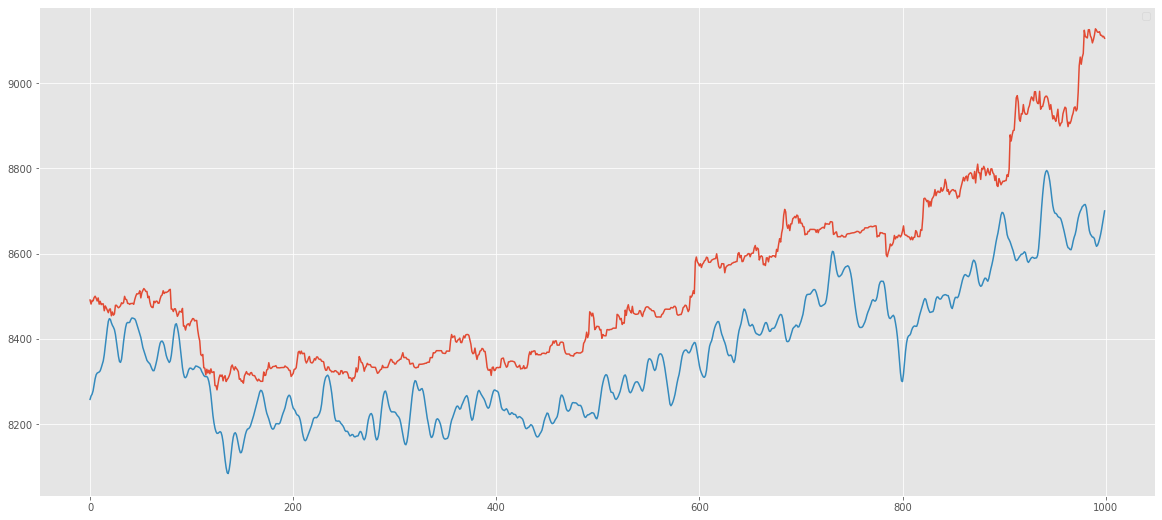

In [110]:
rcParams['figure.figsize'] = 20,9
de_preds = dw.denormalize(preds[:, 0], df, 'close')

plus = df.shape[0] - de_preds.shape[0]

#target = df.columns.get_loc('close')
#plt.plot(y_train, label='Train')
# plt.plot(range(df.shape[0]-plus,df.shape[0]), d.denoise(de_preds, 5), label='Preds')
# plt.plot(range(), df.iloc[:, target], label='Actual')
plt.legend();
_preds = de_preds[-1000:]
_actual = df.iloc[-1000:]
plt.plot(range(len(_actual)), _actual.iloc[:, target])
plt.plot(range(len(_actual)), d.denoise(_preds, 5))


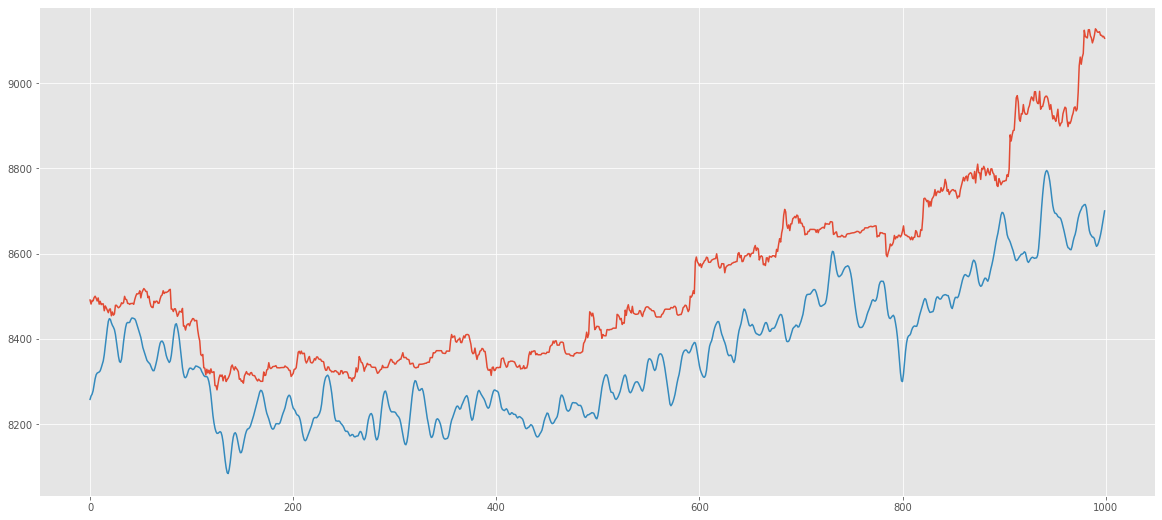

In [111]:
_preds = de_preds[-1000:]
_actual = df.iloc[-1000:]
target = df.columns.get_loc('close')
plt.plot(range(len(_actual)), _actual.iloc[:, target])
plt.plot(range(len(_actual)), d.denoise(_preds, 5))
